In [35]:
# Necessary import
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, timezone
from matplotlib.colors import Normalize
import matplotlib.dates as mdates
from scipy.ndimage import uniform_filter1d
from meteostat import Point, Daily
from sklearn.linear_model import LinearRegression
from scipy.ndimage import uniform_filter1d
import matplotlib.pyplot as plt

# Load extracted data

If the data is not already in `*.csv` your working directory, see `extract_data.py` script (~30min).

In [36]:
raw = pd.read_csv("awn_history.csv", index_col=0)
raw.index = pd.to_datetime(raw.index)
raw.head()

,dateutc,tempf,humidity,windspeedmph,windgustmph,maxdailygust,winddir,winddir_avg10m,uv,solarradiation,...,baromabsin,battin,feelsLikein,dewPointin,aqi_pm25,aqi_pm25_24h,pm25,pm25_24h,batt_25,temp_c
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-03-19 19:49:00+00:00,1679255340000,51.1,97.0,1.79,2.24,11.41,215.0,222.0,1.0,161.07,...,29.193,1.0,73.4,52.6,NaN,NaN,NaN,NaN,NaN,10.611111
2023-03-19 19:50:00+00:00,1679255400000,51.1,98.0,0.89,2.24,11.41,224.0,222.0,1.0,164.01,...,29.190,1.0,73.4,52.6,NaN,NaN,NaN,NaN,NaN,10.611111
2023-03-19 19:55:00+00:00,1679255700000,50.9,97.0,3.58,4.47,11.41,193.0,222.0,1.0,169.73,...,29.187,1.0,73.6,52.7,NaN,NaN,NaN,NaN,NaN,10.500000
2023-03-19 20:00:00+00:00,1679256000000,50.5,98.0,5.14,5.82,11.41,261.0,220.0,2.0,216.83,...,29.187,1.0,73.6,52.7,NaN,NaN,NaN,NaN,NaN,10.277778
2023-03-19 20:05:00+00:00,1679256300000,50.9,98.0,4.47,5.82,11.41,179.0,232.0,1.0,188.56,...,29.187,1.0,73.6,52.7,NaN,NaN,NaN,NaN,NaN,10.500000


# Convert, resample and rename data

In [37]:
# Convert Fahrenheit to Celsius
raw['temp_c'] = (raw['tempf'] - 32) * 5/9

# Resample for daily data
df = raw.resample("D").agg({'temp_c': ['mean', 'min', 'max'],'dailyrainin': 'mean'})

# Flatten column names
df.columns = ['temp_mean', 'temp_min', 'temp_max', 'rain']
df = df.dropna()
df['rain'] = df['rain'].values * 25.4 # Convert inches to mm
df.index = df.index.to_period('D').to_timestamp()
df.head()

,temp_mean,temp_min,temp_max,rain
timestamp,,,,
2023-03-19,11.086057,10.277778,11.777778,26.231725
2023-03-20,9.083140,4.888889,13.388889,7.926917
2023-03-21,6.549961,3.277778,11.888889,4.137201
2023-03-22,8.396531,5.777778,13.500000,19.504243
2023-03-23,9.428819,5.888889,14.277778,5.630333


# Website plot: entire season with temperature and rain


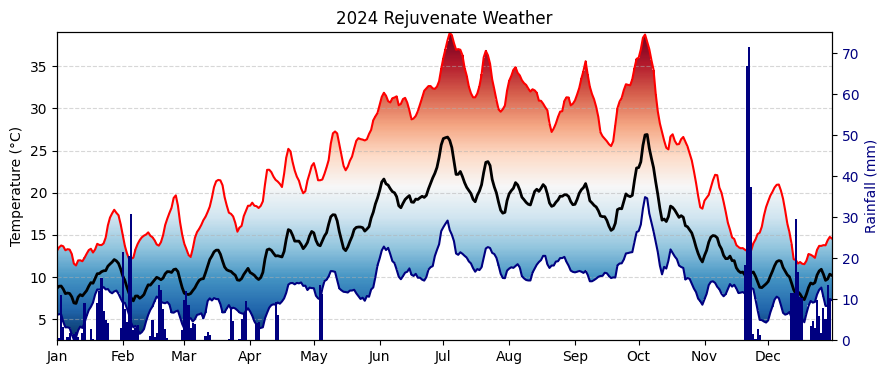

In [38]:
def plot_season(df, year=2024, window=7, file_name=None): 
    """
    Plot the weather data for a specific year with a rolling window.
    Parameters:
    - df: DataFrame containing weather data
    - year: Year to plot
    - window: Rolling window size for smoothing
    - file_name: Optional filename to save the plot
    """

    # select the year
    df = df[df.index.year == year]

    # Smooth values when necessary
    x = df.index
    y_mean = uniform_filter1d(df['temp_mean'], size=window, mode='mirror')
    y_min = uniform_filter1d(df['temp_min'], size=window, mode='mirror')
    y_max = uniform_filter1d(df['temp_max'], size=window, mode='mirror')
    rain = df.rain.values

    # Plot
    fig, ax1 = plt.subplots(figsize=(10, 4))

    # Twin axis
    ax2 = ax1.twinx()

    # Plot mean temperature
    ax1.plot(x, y_mean, color='black', linewidth=2, zorder=2)
    
    # Plot temperature range
    cmap = plt.get_cmap('RdBu_r')
    vmin, vmax = y_min.min(), y_max.max()
    norm = Normalize(vmin=vmin, vmax=vmax)
    x_grid, y_grid = np.meshgrid(x, np.linspace(vmin, vmax, 256))
    mesh = ax1.pcolormesh(x_grid, y_grid, y_grid, cmap=cmap, norm=norm, antialiased=True, shading='auto', zorder=1)

    # Create a mask to hide the area outside the min and max temperature
    above = (y_grid >= y_min.reshape(1, -1).repeat(y_grid.shape[0], axis=0))
    below = (y_grid <= y_max.reshape(1, -1).repeat(y_grid.shape[0], axis=0))
    mask = above & below
    mesh.set_alpha(np.where(mask, 1, 0))

    # Plot min and max temperature to round out the graph
    ax1.plot(x, y_min, color='navy', linewidth=1.5, zorder=3)
    ax1.plot(x, y_max, color='red', linewidth=1.5,zorder=3)
    
    # Rainfall bars
    ax2.bar(x, rain, width=1, color='navy', alpha=1, zorder=4)

    # Adjust layout
    ax1.set_ylabel("Temperature (°C)", color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax2.set_ylabel("Rainfall (mm)", color='navy')
    ax2.tick_params(axis='y', labelcolor='navy')
    ax2.xaxis.set_major_locator(mdates.MonthLocator())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax2.set_xlabel("Month")
    ax2.set_xlim(x[0], x[-1])
    ax1.grid(True, which='major', axis='y', linestyle='--', alpha=0.5)
    plt.title(f"{year} Rejuvenate Weather")

    # To save
    if file_name:
        plt.savefig(f"examples/{file_name}_{year}_season.svg", format='svg', dpi=300)

    # Show plot
    plt.show()

# plot_season(df, year=2024, window=7)
plot_season(df, year=2024, window=7, file_name="website")  # uncomment to save the plot


# Label plot: minimalist temperature fluctuation

## Barcode

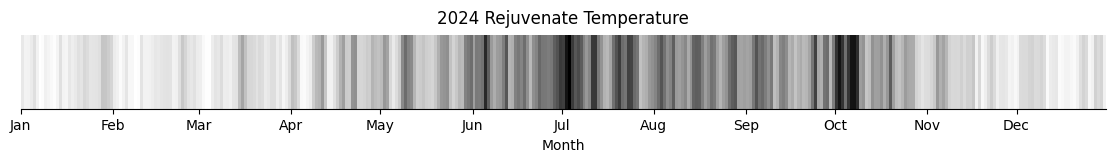

In [28]:
def plot_barcode(df, year=2024, file_name=None):
    """
    Plot a barcode of daily temperatures for a given year.
    Parameters:
    - df: DataFrame containing weather data
    - year: Year to plot
    - file_name: Optional filename to save the plot
    """
    # Select the year
    df = df[df.index.year == year]

    # Extract temperature data
    temps = df['temp_mean']
    dates = df.index

    # Normalize temps to [0,1]
    norm = (temps - temps.min()) / (temps.max() - temps.min())
    
    # Grayscale mapping: darker = warmer
    colors = plt.cm.Greys(norm)

    fig, ax = plt.subplots(figsize=(14, 1))
    ax.bar(dates, np.ones_like(norm), color=colors, width=1, align='edge')

    # Adjust layout
    ax.set_yticks([])
    ax.set_ylabel("")
    ax.set_xlim(dates[0], dates[-1])
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.set_xlabel("Month")
    for spine in ['top', 'right', 'left']:
        ax.spines[spine].set_visible(False)

    plt.title(f"{dates.year[0]} Rejuvenate Temperature")

    if file_name:
        plt.savefig(f"{file_name}_{year}_barcode.svg", format='svg', dpi=300)

    plt.show()

plot_barcode(df)

## Anomaly

### Calibrating of meteostat data to rejuvenate vineyard
https://meteostat.net/en/place/us/glen-ellen?s=KO690&t=2015-05-01/2015-05-31

In [39]:
# Define Rejuvenate location
lat, lon, alt = 38.36398, -122.55438, 192
rejuvenate = Point(lat, lon, alt)
start = datetime(1980, 1, 1)          # as far back as you like
end   = datetime.now()                # up to today

# 3) Download daily data
data = Daily(rejuvenate, start, end)
df_meteo   = data.fetch()

# 5) (Optional) Rename columns for clarity
df_meteo = df_meteo[['tavg', 'tmin', 'tmax', 'prcp']].rename(columns={
    'tavg': 'temp_mean',
    'tmin': 'temp_min',
    'tmax': 'temp_max',
    'prcp': 'rain',
})

df_meteo.head()

,temp_mean,temp_min,temp_max,rain
time,,,,
2000-01-01,4.2,-1.9,10.1,NaN
2000-01-02,5.4,-0.9,11.1,NaN
2000-01-03,5.6,-1.9,14.1,NaN
2000-01-04,4.8,-0.9,10.1,NaN
2000-01-05,5.1,-1.9,15.1,NaN


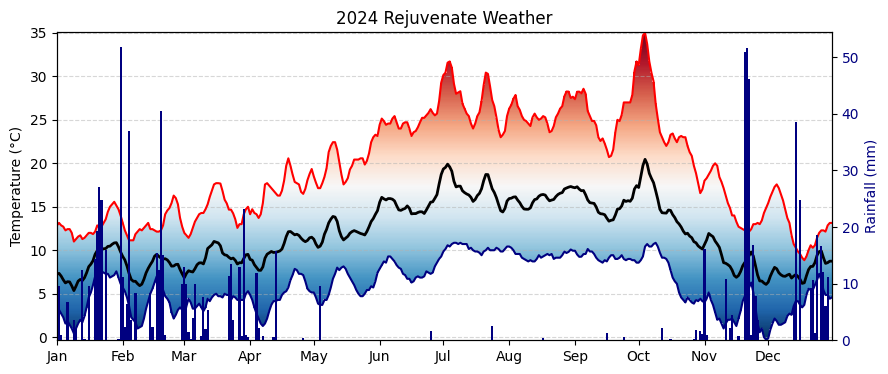

In [40]:
plot_season(df_meteo, year=2024, window=7)

The data from meteostat seems to be a bit less warm than the data collected on Rejuvenate vineyard. We use the existing overlap for the calibration.

In [41]:
# Find the overlap between the two datasets
df = df.rename(columns={'temp_mean': 'temp'})[['temp', 'rain']]
df_meteo = df_meteo.rename(columns={'temp_mean': "temp_m", 'rain': "rain_m"})[['temp_m', 'rain_m']]
combined = df.join(df_meteo, how='inner')

# Fit a linear regression model for temperature and rain
models = {}
for obs_col, met_col in [('temp', 'temp_m'),('rain','rain_m')]:
    xy = combined[[obs_col, met_col]].dropna()
    reg = LinearRegression().fit(xy[[met_col]],xy[obs_col])
    models[obs_col] = reg
    print(f"{obs_col} ← {met_col}  R²={reg.score(xy[[met_col]], xy[obs_col]):.3f}")

# 
calibrated = df_meteo.copy()
for obs_col, met_col in [('temp', 'temp_m'),('rain','rain_m')]:
    calibrated[f"{obs_col}_cal"] = pd.Series(models[obs_col].predict(calibrated[[met_col]].dropna()), index=calibrated[[met_col]].dropna().index)

# When the Rejuvenate collected data is missing, use Calibrated Meteostat data
df = calibrated.join(df.rename(columns={'temp': 'temp_rej', 'rain': 'rain_rej'}), how='outer')
df['temp'] = df['temp_rej'].combine_first(df['temp_cal'])
df['rain'] = df['rain_rej'].combine_first(df['rain_cal'])
df["dayofyear"] = df.index.dayofyear
df["year"]      = df.index.year
df = df[['year', 'dayofyear','temp', 'temp_rej', 'temp_cal', 'rain', 'rain_rej', 'rain_cal']]
df.head(10)

temp ← temp_m  R²=0.853
rain ← rain_m  R²=0.365


,year,dayofyear,temp,temp_rej,temp_cal,rain,rain_rej,rain_cal
2000-01-01,2000,1,5.625079,NaN,5.625079,NaN,NaN,NaN
2000-01-02,2000,2,7.040874,NaN,7.040874,NaN,NaN,NaN
2000-01-03,2000,3,7.276840,NaN,7.276840,NaN,NaN,NaN
2000-01-04,2000,4,6.332976,NaN,6.332976,NaN,NaN,NaN
2000-01-05,2000,5,6.686925,NaN,6.686925,NaN,NaN,NaN
2000-01-06,2000,6,5.271130,NaN,5.271130,NaN,NaN,NaN
2000-01-07,2000,7,6.804908,NaN,6.804908,NaN,NaN,NaN
2000-01-08,2000,8,8.338686,NaN,8.338686,NaN,NaN,NaN
2000-01-09,2000,9,10.108431,NaN,10.108431,NaN,NaN,NaN
2000-01-10,2000,10,NaN,NaN,NaN,NaN,NaN,NaN


### Plot 

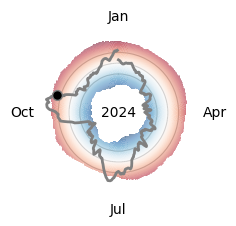

In [ ]:
def plot_anomalies_v1(df, year=2024, window=7, harvest=pd.to_datetime('2024-10-17'), file_name=None):
    """
    Plot temperature anomalies for a specific year using a polar plot.
    Parameters:
    - df: DataFrame containing weather data
    - year: Year to plot
    - window: Rolling window size for smoothing
    - harvest: Date of harvest
    - file_name: Optional filename to save the plot
    """

    # Make sure window is odd
    if window % 2 == 0:
        window += 1
    
    # Calculate climat (average for each day of year)
    # Handle leap years by using dayofyear 366 as dayofyear 365
    df['dayofyear_clim'] = df['dayofyear'].clip(upper=365)
    climat = df.groupby('dayofyear_clim')['temp'].mean()
    climat_bottom = df.groupby('dayofyear_clim')['temp'].quantile(0.25)
    climat_top = df.groupby('dayofyear_clim')['temp'].quantile(0.75)

    
    # Compute anomalies by subtracting climat
    df['anomaly'] = df.apply(lambda row: row['temp'] - climat[row['dayofyear_clim']], axis=1).fillna(0)
    
    # Apply smoothing
    df['anomaly'] = uniform_filter1d(df['anomaly'], size=window, mode='mirror')
    anomaly_bottom = uniform_filter1d(climat_bottom - climat, size=window, mode='wrap')
    anomaly_top = uniform_filter1d(climat_top - climat, size=window, mode='wrap')

    # Fill in the last day of the year with the first day of the next year
    anomaly_bottom = np.append(anomaly_bottom, anomaly_bottom[0])
    anomaly_top = np.append(anomaly_top, anomaly_top[0])
    days = np.append(climat_top.index, climat_top.index[0])

    # Create polar plot
    fig = plt.figure(figsize=(2, 2))
    ax = plt.subplot(111, projection='polar')
    
    # Convert day of year to radians (0-2π)
    theta = np.linspace(0, 2*np.pi, 366, endpoint=False)  # Includes day 366
    
    # Create colormap and normalization
    cmap = plt.get_cmap('RdBu_r')
    vmin = anomaly_bottom.min()
    vmax = anomaly_top.max()
    norm = Normalize(vmin=vmin, vmax=vmax)
    
    # Create a grid for pcolormesh
    theta_grid, y_grid = np.meshgrid(theta, np.linspace(vmin, vmax, 256))
    
    # Plot using pcolormesh with the mask
    value = y_grid.copy()
    mask = (y_grid >= anomaly_bottom.reshape(1, -1).repeat(y_grid.shape[0], axis=0)) & (y_grid <= anomaly_top.reshape(1, -1).repeat(y_grid.shape[0], axis=0))
    mesh = ax.pcolormesh(theta_grid, y_grid, value, 
                        cmap=cmap, norm=norm, antialiased=True,
                        shading='auto', zorder=7)
    mesh.set_alpha(np.where(mask, 0.6, 0))

    # Plot the anomaly of the selected year
    cd = df.year == year
    ax.plot(theta[df['dayofyear'][cd]-1], df['anomaly'][cd], color='grey', linewidth=2, zorder=9)


    # Plot harvest date
    harvest_day = harvest.dayofyear
    harvest_theta = 2 * np.pi * (harvest_day - 1) / 365.0
    ax.scatter(harvest_theta, 
            df['anomaly'][cd][harvest_day-1],  # Place at center radius
            marker='.',      # regular hexagon
            s=200,                 # size
            # facecolor='#8A2BE2',   # blue‑violet purple
            facecolor='black',   # blue‑violet purple
            edgecolor='grey',     # crisp outline
            linewidth=1,
            zorder=10)  # Ensure markers appear on top
    
    
    # Adjust layout
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    month_positions = np.linspace(0, 2*np.pi, 4, endpoint=False)
    month_names = ['Jan',  'Apr', 'Jul', 'Oct']
    ax.set_xticks(month_positions)
    ax.set_xticklabels(month_names)
    ax.set_yticks([-1, 0, 1])
    ax.set_yticklabels(['', '', ''])
    ax.grid(False, axis='x')
    ymin = min(anomaly_bottom.min(), df['anomaly'][cd].min())
    ymax = max(anomaly_top.max(), df['anomaly'][cd].max())
    margin = 0.5 * (ymax - ymin)
    ax.set_ylim(ymin - margin, ymax+0.35)
    ax.text(0, ax.get_ylim()[0], str(year), 
           fontsize=10, 
           ha='center', 
           va='center', 
           color='black',
           transform=ax.transData)
    ax.spines['polar'].set_visible(False)
    
    # Save plot if file_name is provided
    if file_name:
        plt.savefig(f'examples/{file_name}_{year}_label.svg', format='svg', dpi=300, bbox_inches='tight')
    plt.show()

plot_anomalies_v1(df, year=2024, window=30) #, file_name="rejuvenate")

Another style

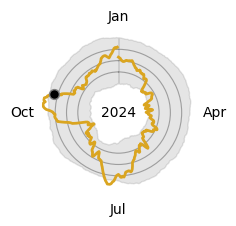

In [33]:
def plot_anomalies_v2(df, year=2024, window=7, harvest=pd.to_datetime('2024-10-17'), file_name=None):
    """
    Plot temperature anomalies in a polar plot after removing climatology and applying smoothing.
    
    Parameters:
    - df: DataFrame with columns ['temp', 'dayofyear', 'year']
    - window: smoothing window size in days (must be odd)
    """
    
    # Make sure window is odd
    if window % 2 == 0:
        window += 1
    
    # Calculate climat (average for each day of year)
    # Handle leap years by using dayofyear 366 as dayofyear 365
    df['dayofyear_clim'] = df['dayofyear'].clip(upper=365)
    climat = df.groupby('dayofyear_clim')['temp'].mean()
    climat_bottom = df.groupby('dayofyear_clim')['temp'].quantile(0.25)
    climat_top = df.groupby('dayofyear_clim')['temp'].quantile(0.75)
    
    # Compute anomalies by subtracting climat
    df['anomaly'] = df.apply(lambda row: row['temp'] - climat[row['dayofyear_clim']], axis=1).fillna(0)
    
    # Apply smoothing
    df['anomaly'] = uniform_filter1d(df['anomaly'], size=window, mode='mirror')
    anomaly_bottom = uniform_filter1d(climat_bottom - climat, size=window, mode='wrap')
    anomaly_top = uniform_filter1d(climat_top - climat, size=window, mode='wrap')

    # Fill in the last day of the year with the first day of the next year
    anomaly_bottom = np.append(anomaly_bottom, anomaly_bottom[0])
    anomaly_top = np.append(anomaly_top, anomaly_top[0])
    days = np.append(climat_top.index, climat_top.index[0])

    # Create polar plot
    fig = plt.figure(figsize=(2, 2))
    ax = plt.subplot(111, projection='polar')
    
    # Convert day of year to radians (0-2π)
    theta = np.linspace(0, 2*np.pi, 366, endpoint=False)  # Includes day 366
    
    # Plot temperature
    ax.fill_between(theta[days-1], anomaly_top, anomaly_bottom, color='black', alpha=0.1, zorder=7)
    cd = df.year == year
    ax.plot(theta[df['dayofyear'][cd]-1], df['anomaly'][cd], color='goldenrod', linewidth=2, zorder=9)

    # Plot harvest date
    harvest_day = harvest.dayofyear
    harvest_theta = 2 * np.pi * (harvest_day - 1) / 365.0
    ax.scatter(harvest_theta, 
            df['anomaly'][cd][harvest_day-1],
            marker='.',
            s=200,
            facecolor='black',
            edgecolor='grey',
            linewidth=1,
            zorder=10)
    
    # Adjust layout
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    month_positions = np.linspace(0, 2*np.pi, 4, endpoint=False)
    month_names = ['Jan', 'Apr', 'Jul', 'Oct']
    ax.set_xticks(month_positions)
    ax.set_xticklabels(month_names)
    ax.set_yticks([-1, 0, 1])
    ax.set_yticklabels(['', '', ''])
    ax.grid(False, axis='x')
    ymin = min(anomaly_bottom.min(), df['anomaly'][cd].min())
    ymax = max(anomaly_top.max(), df['anomaly'][cd].max())
    margin = 0.5 * (ymax - ymin)
    ax.set_ylim(ymin - margin, ymax)
    ax.text(0, ax.get_ylim()[0], str(year), 
           fontsize=10, 
           ha='center', 
           va='center', 
           color='black',
           transform=ax.transData)
    ax.spines['polar'].set_visible(False)

    # Save plot if file_name is provided
    if file_name:
        plt.savefig(f'{file_name}.svg', format='svg', dpi=300, bbox_inches='tight')

    plt.show()

plot_anomalies_v2(df, year=2024, window=30) #, file_name="rejuvenate_temp_2024_v2")